<a href="https://www.kaggle.com/code/yaaangzhou/zzz-reduce-memory-preprocessing-and-eda?scriptVersionId=142662918" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[ZZz]Reduce Memory, Preprocessing and EDA**

**8 Sep 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">[ZZz]Reduce Memory, Preprocessing and EDA</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Detect sleep onset and wake from wrist-worn accelerometer data</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Overview</center>

1. The goal of this competition is to detect sleep onset and wake.
2. The dataset comprises about 500 multi-day recordings of wrist-worn accelerometer data annotated with two event types: onset, the beginning of sleep, and wakeup, the end of sleep. 
3. According to the description, only sleep time of more than 30 minutes in the data set is considered to be sleeping.

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Some Insights and Tricks</center>

1. @[Andrada](https://www.kaggle.com/andradaolteanu) provides a [method](https://www.kaggle.com/code/andradaolteanu/zzz-good-night-sleep-with-80-memory-reduction) that reduces memory usage by 73% for `train_events` and 41% for `train_series`.

# 0. Imports

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import datetime as dt
from copy import deepcopy
from functools import partial
from itertools import combinations
from itertools import groupby

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Tests
from scipy.stats import f_oneway

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# 1. Load Data

In [3]:
train_events = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_series = pd.read_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet")

test_series  = pd.read_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet")
sample_submission = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv')

In [4]:
train_events.sample(3)

,series_id,night,event,step,timestamp
10778,cca14d1966c1,7,onset,106260.0,2018-03-25T21:20:00-0400
9865,bfa54bd26187,16,wakeup,270540.0,2017-12-23T07:30:00-0500
8064,971207c6a525,11,onset,NaN,NaN


In [5]:
train_series.sample(3)

,series_id,step,timestamp,anglez,enmo
92363715,c75b4b207bea,148275,2019-03-14T01:56:15-0500,62.106201,0.0000
55900694,752900afe3a6,41294,2017-11-24T01:51:10-0500,47.159199,0.0000
119033598,eef041dd50aa,69618,2018-12-15T12:41:30-0500,86.243896,0.0002


# 2. Reduce Memory

In [6]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float16)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [7]:
all_data = {'train_series': train_series, 'test_series': test_series, 'train_events': train_events}

for name, data in all_data.items():
    print(f'Reducing dataset {name}')
    all_data[name] = reduce_mem_usage(data)
    print('=='*20)

Reducing dataset train_series
Memory usage of dataframe is 3416.54 MB
Memory usage after optimization is: 2928.46 MB
Decreased by 14.29%
Reducing dataset test_series
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 21.21%
Reducing dataset train_events
Memory usage of dataframe is 0.55 MB
Memory usage after optimization is: 0.40 MB
Decreased by 27.49%


# 3. EDA

We can visualize each table. Here are some of our concerns:

1. The daily sleep status of each user (each ID).
2. Each user's sleep status in each hour.

Let's do this.

In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum

In [9]:
summary(train_events)

,dtypes,missing#,missing%,uniques,count
series_id,object,0,0.000000,277,14510
night,int8,0,0.000000,84,14510
event,object,0,0.000000,2,14510
step,float32,492300,33.928325,7501,9587
timestamp,object,492300,33.928325,9362,9587


In [10]:
train_events.dropna(inplace=True)
train_events.shape

(9587, 5)

**It can be noticed that more than 30 percent of the time the data is missing values. This means that there are days when users don't record their sleep. In this case I will delete the missing records.**

There are no missing values in `train_series`, but due to the large amount of data, this will take a long time to run.

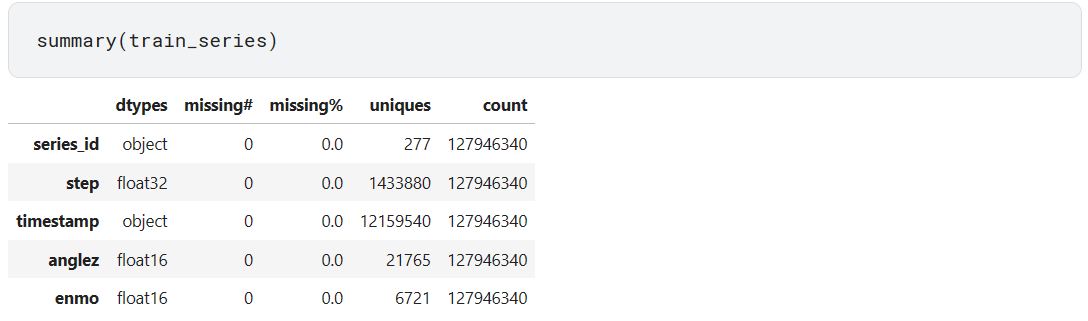

In [11]:
# summary(train_series)

## Preprocessing

In [12]:
def time_preprocessing(df):
    df['date'] = df['timestamp'].str.split('T', expand=True)[0]
    df['time'] = df['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
    df['timestamp'] = pd.to_datetime(df['date']+' '+df['time'])
    df['hour'] = df['timestamp'].dt.hour
    return df    

## Dataset `train_events`

In [13]:
# Preprocessing

train_events = time_preprocessing(train_events)

### Average number of days logged per user

In [14]:
train_events.groupby('series_id')['date'].nunique().to_frame().reset_index().sort_values(by='date',ascending=False)

,series_id,date
211,d043c0ca71cd,40
110,6d6b9d22d48a,38
242,e586cbfa7762,37
109,6ca4f4fca6a2,37
169,a9a2f7fac455,36
...,...,...
90,5aad18e7ce64,2
190,c107b5789660,2
163,a2b0a64ec9cf,1
173,aed3850f65f0,1


In [15]:
train_events.groupby('series_id')['date'].nunique().to_frame().reset_index().sort_values(by='date',ascending=False).describe()

,date
count,269.000000
mean,19.959108
std,8.528825
min,1.000000
25%,14.000000
50%,22.000000
75%,24.000000
max,40.000000


**On average, each user logs 20 days of sleep.**

### Time distribution of user behavior

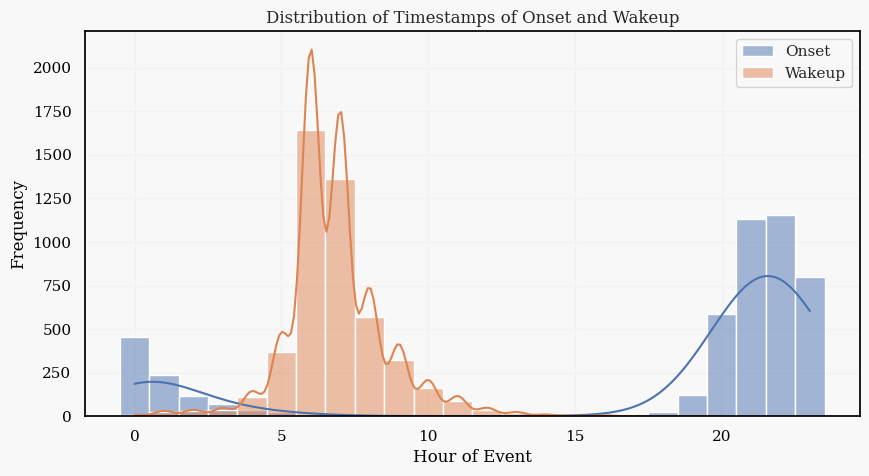

In [16]:
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

plt.figure(figsize=(10, 5))
sns.histplot(df_onset['hour'], kde=True, label='Onset', discrete=True)  
sns.histplot(df_wakeup['hour'], kde=True, label='Wakeup', discrete=True) 

plt.xlabel('Hour of Event')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps of Onset and Wakeup')
plt.legend()

plt.show()

**We can see that the user behavior distribution is consistent.**

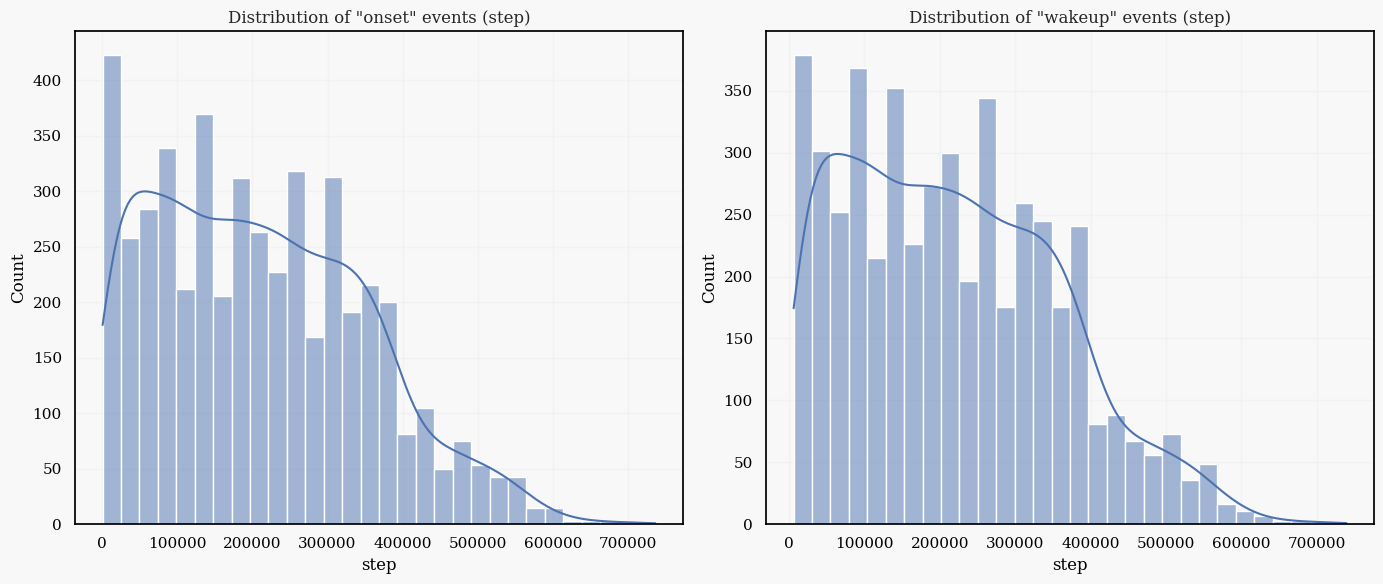

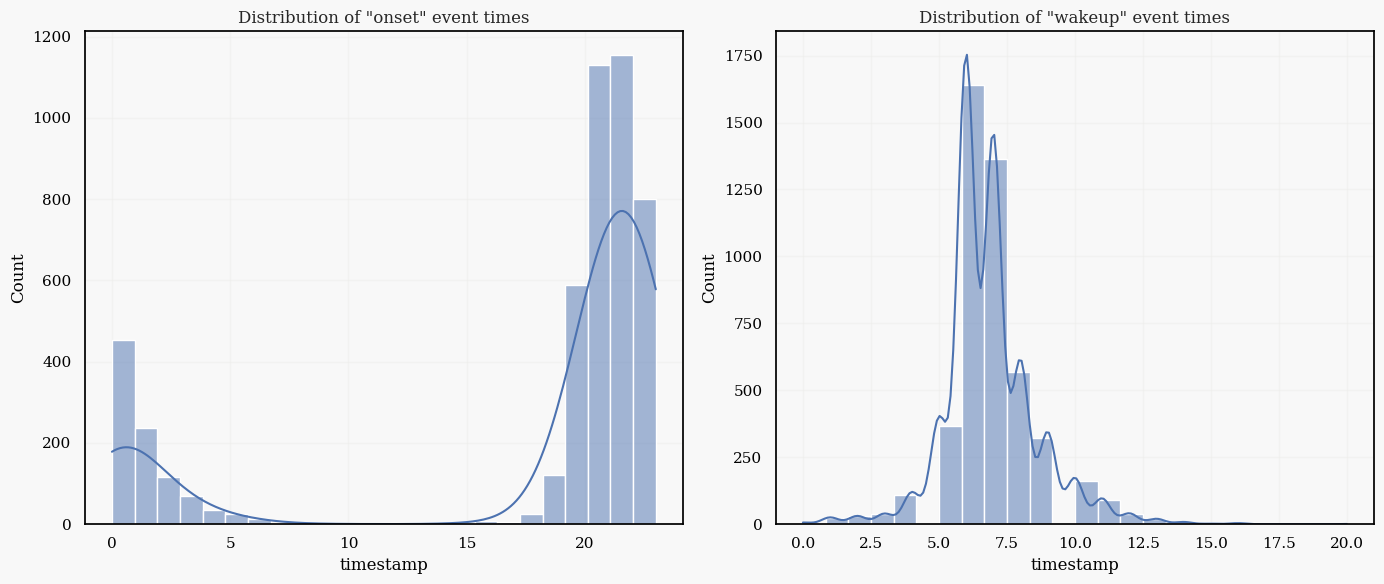

In [17]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_onset['step'], bins=30, kde=True)
plt.title('Distribution of "onset" events (step)')

plt.subplot(1, 2, 2)
sns.histplot(df_wakeup['step'], bins=30, kde=True)
plt.title('Distribution of "wakeup" events (step)')

plt.tight_layout()
plt.show()

# Plot the distribution of "onset" and "wakeup" event times
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_onset['timestamp'].dt.hour, bins=24, kde=True)
plt.title('Distribution of "onset" event times')

plt.subplot(1, 2, 2)
sns.histplot(df_wakeup['timestamp'].dt.hour, bins=24, kde=True)
plt.title('Distribution of "wakeup" event times')

plt.tight_layout()
plt.show()

## Dataset `train_series` with top 5 ids

**Since there is too much data in the train series, I will only use the data of the top 8 IDs with the largest amount of data.**

In [18]:
top5id = train_events.groupby('series_id')['date'].nunique().to_frame().sort_values(by='date',ascending=False).head(5).index
top5id

Index(['d043c0ca71cd', '6d6b9d22d48a', 'e586cbfa7762', '6ca4f4fca6a2',
       'a9a2f7fac455'],
      dtype='object', name='series_id')

In [19]:
train_series_top5 = train_series[train_series['series_id'].isin(top5id)]
train_series_top5.shape

(3465900, 5)

In [20]:
# Preprocessing

train_series_top5 = time_preprocessing(train_series_top5)
train_series_top5.sample(3)

,series_id,step,timestamp,anglez,enmo,date,time,hour
51044859,6ca4f4fca6a2,422559.0,2018-12-15 23:38:15,80.312500,0.000000,2018-12-15,23:38:15,23
50932027,6ca4f4fca6a2,309727.0,2018-12-09 10:55:35,-10.171875,0.105225,2018-12-09,10:55:35,10
114020755,e586cbfa7762,377035.0,2018-10-04 06:09:35,50.906250,0.001200,2018-10-04,06:09:35,6


In [21]:
# code source: https://www.kaggle.com/code/patrick0302/viz-of-sleeping-time-series

def plot_series_with_events(series_id, train_series, train_events):
    sample_serie = train_series[train_series['series_id'] == series_id]
    # Filter event data based on the series_id
    sample_events = train_events[train_events['series_id'] == series_id]
    
    sample_onset = sample_events.loc[sample_events['event'] == 'onset', 'timestamp'].dropna()
    sample_wakeup = sample_events.loc[sample_events['event'] == 'wakeup', 'timestamp'].dropna()
    
    # Helper function to plot data and events
    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 3))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=1)
        
        for onset in sample_onset:
            plt.axvline(x=onset, color='r', linestyle='--', label='onset')
            
        for wakeup in sample_wakeup:
            plt.axvline(x=wakeup, color='g', linestyle='--', label='wakeup')
            
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
        
        plt.legend(new_handles, new_labels)
        plt.xlabel('Timestamp')
        plt.ylabel(ylabel)
        plt.title(f'{ylabel} over Time with Event Flags - '+series_id)
        plt.show()
    
    # Plot enmo and anglez
    plot_data_and_events('enmo', 'ENMO Value')
    plot_data_and_events('anglez', 'anglez Value')

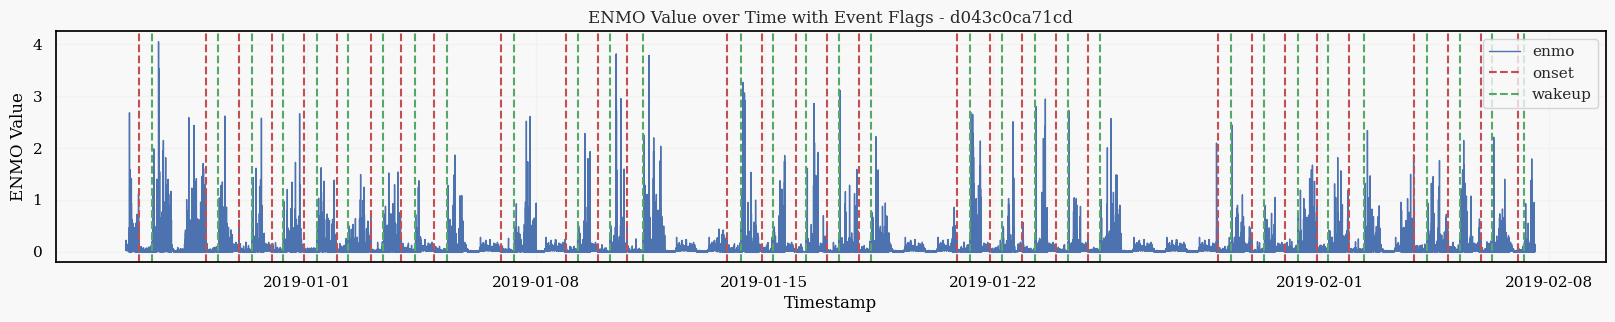

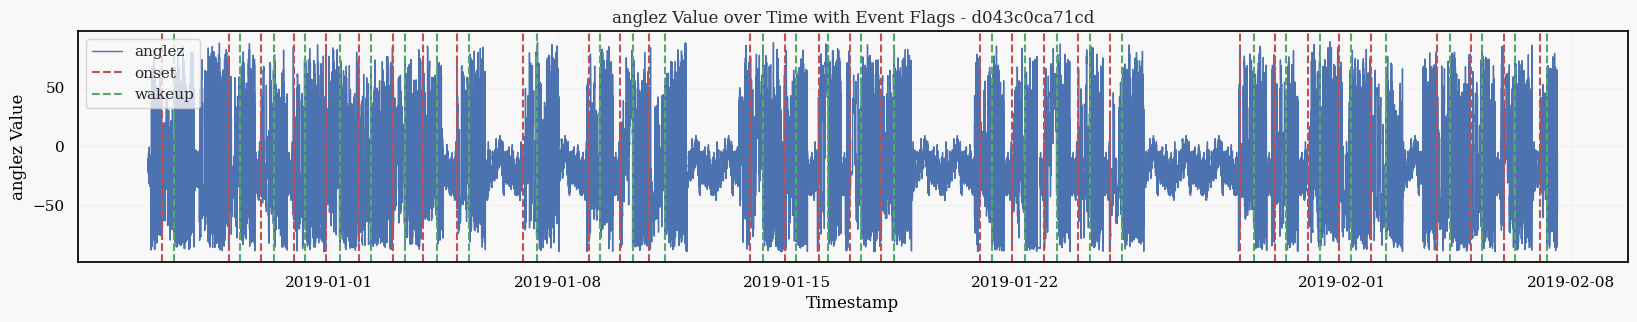

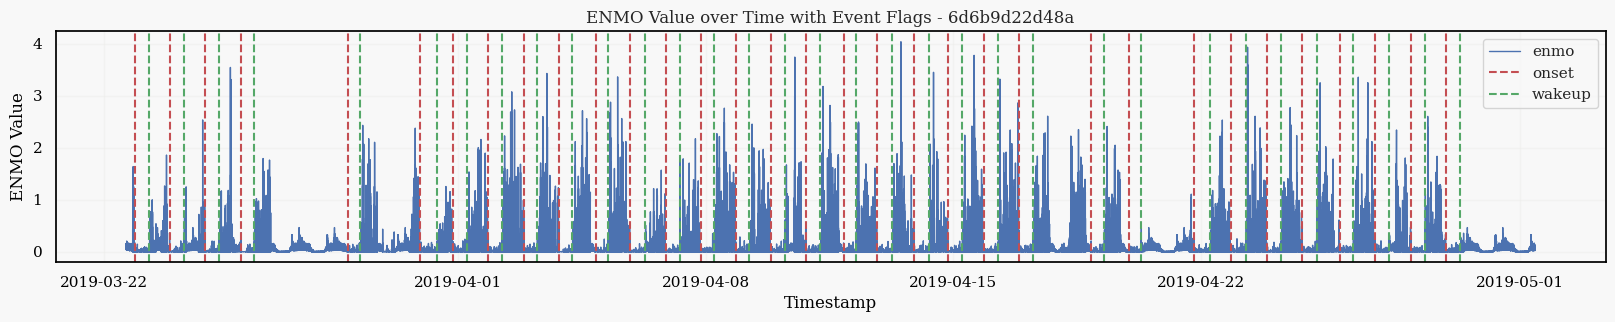

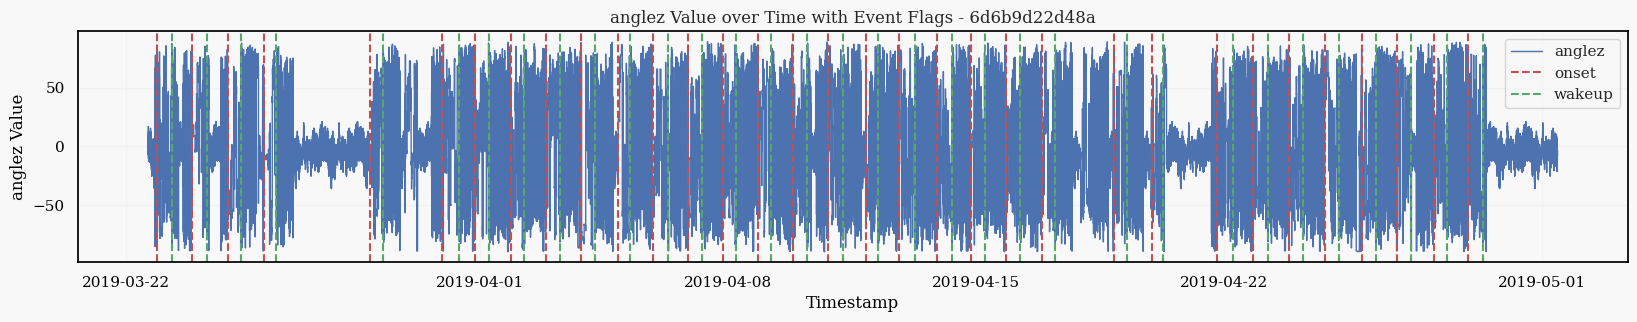

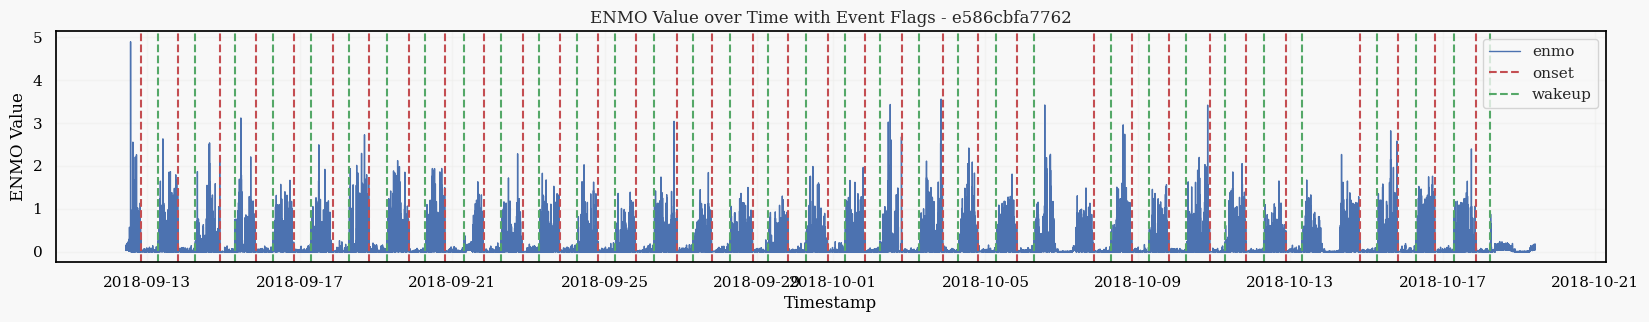

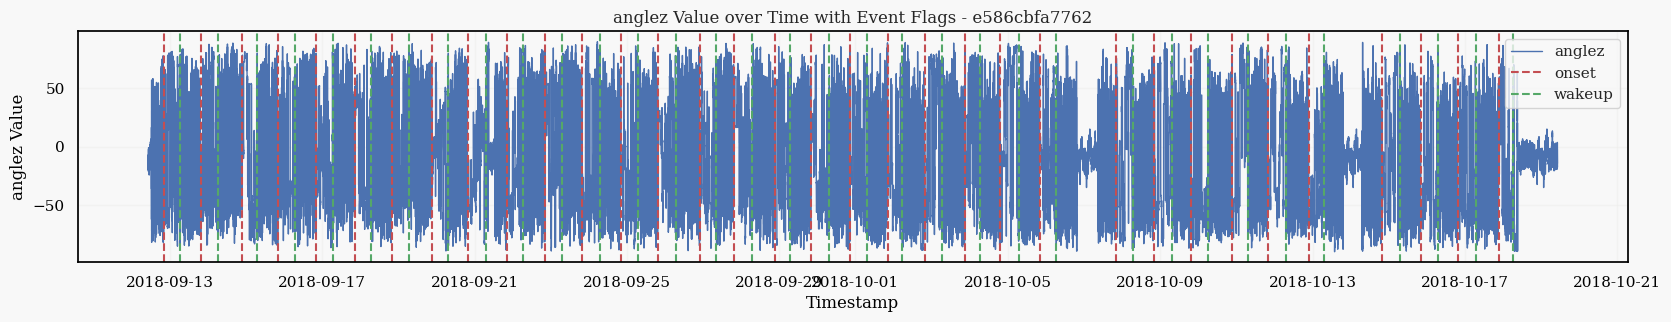

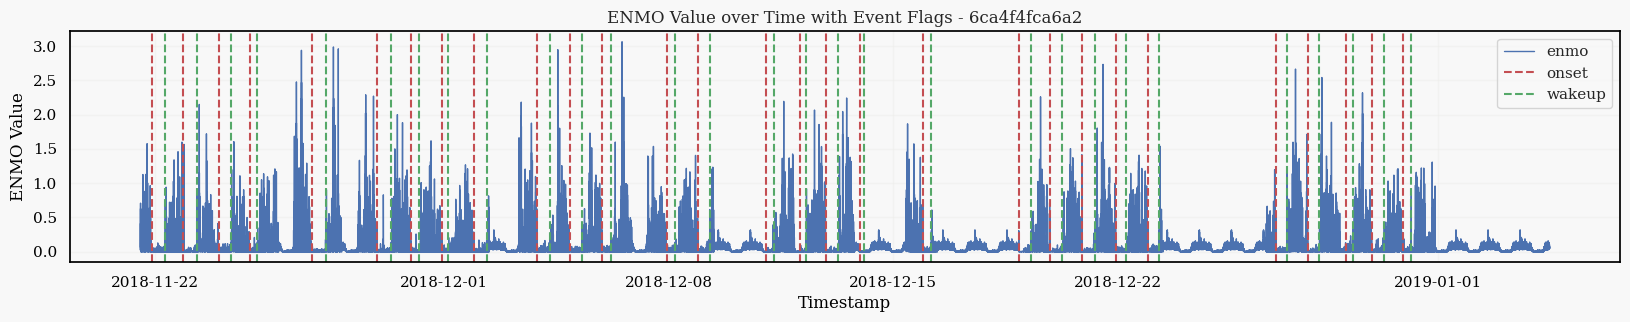

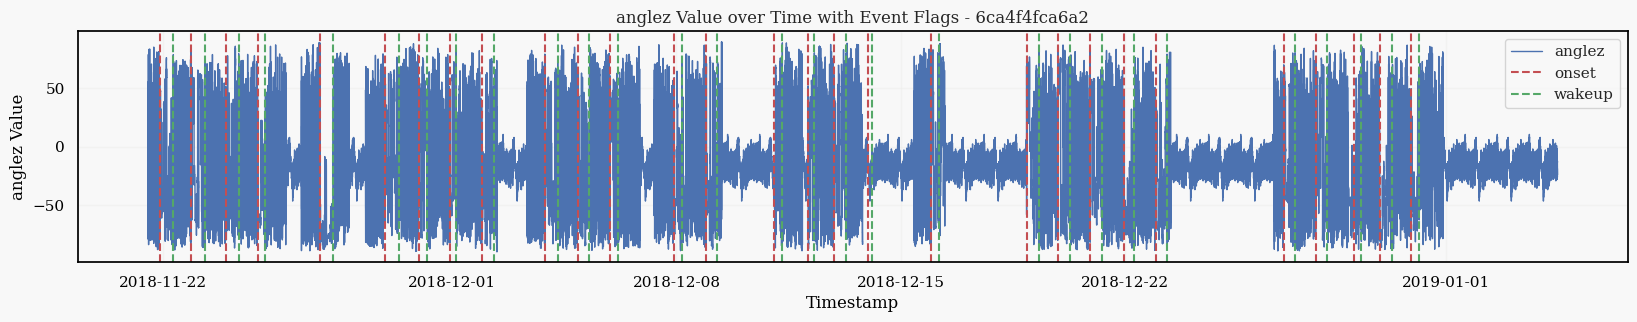

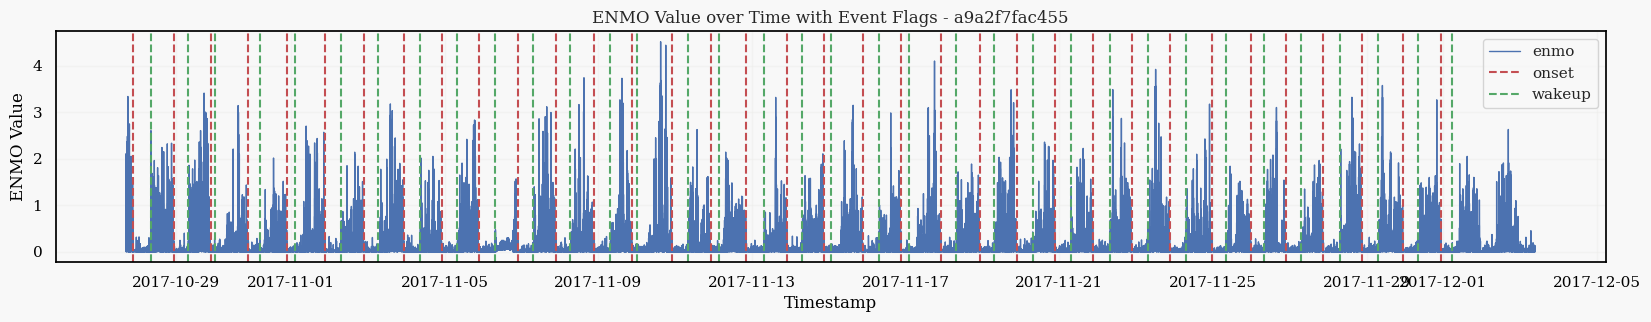

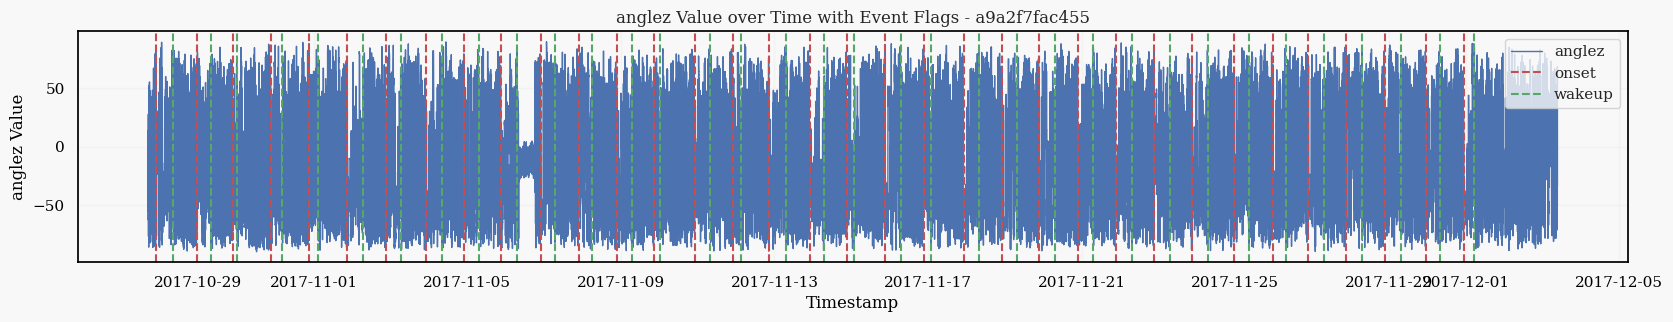

In [22]:
for series_id in top5id:
    plot_series_with_events(series_id, train_series_top5, train_events)

### Plots of steps

In [23]:
train_events

,series_id,night,event,step,timestamp,date,time,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018-08-14,22:26:00,22
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018-08-15,06:41:00,6
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018-08-15,19:37:00,19
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018-08-16,05:41:00,5
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018-08-16,23:03:00,23
...,...,...,...,...,...,...,...,...
14503,fe90110788d2,32,wakeup,547152.0,2017-09-05 09:26:00,2017-09-05,09:26:00,9
14504,fe90110788d2,33,onset,556560.0,2017-09-05 22:30:00,2017-09-05,22:30:00,22
14505,fe90110788d2,33,wakeup,560604.0,2017-09-06 04:07:00,2017-09-06,04:07:00,4
14506,fe90110788d2,34,onset,574620.0,2017-09-06 23:35:00,2017-09-06,23:35:00,23


In [24]:
def get_series_data(series_id,train_series,train_events):
    data_series = train_series[train_series['series_id']==series_id]
    data_events = train_events[train_events['series_id']==series_id]
    
    data_events["step"]  = data_events["step"].astype("int")
    data_events["awake"] = data_events["event"].replace({"onset":1,"wakeup":0})
    
    data = pd.merge(data_series,data_events[['step','awake']],on='step',how='left')
    data['awake'] = data['awake'].bfill(axis='rows')
    data['awake'] = data['awake'].fillna(1) # awake
    data["awake"] = data["awake"].astype("int")
    return data

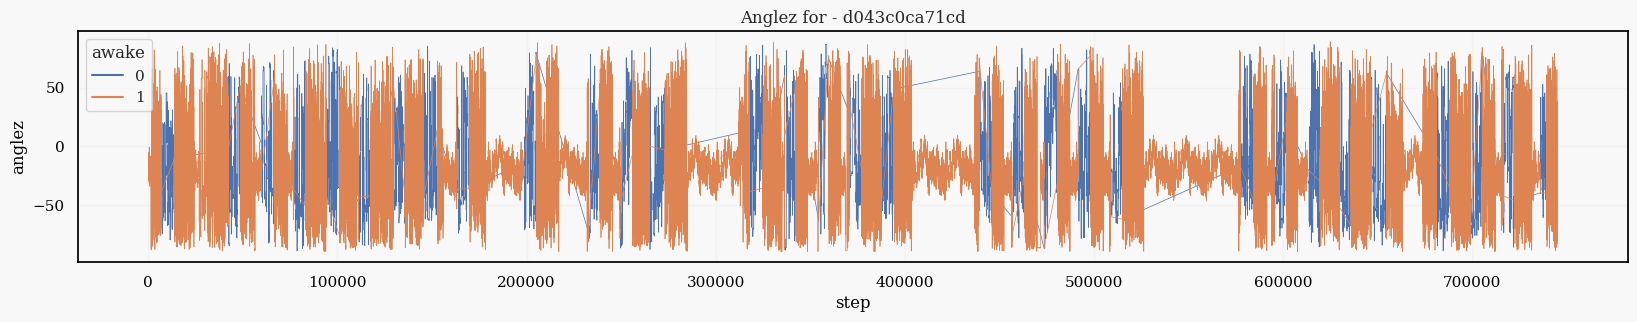

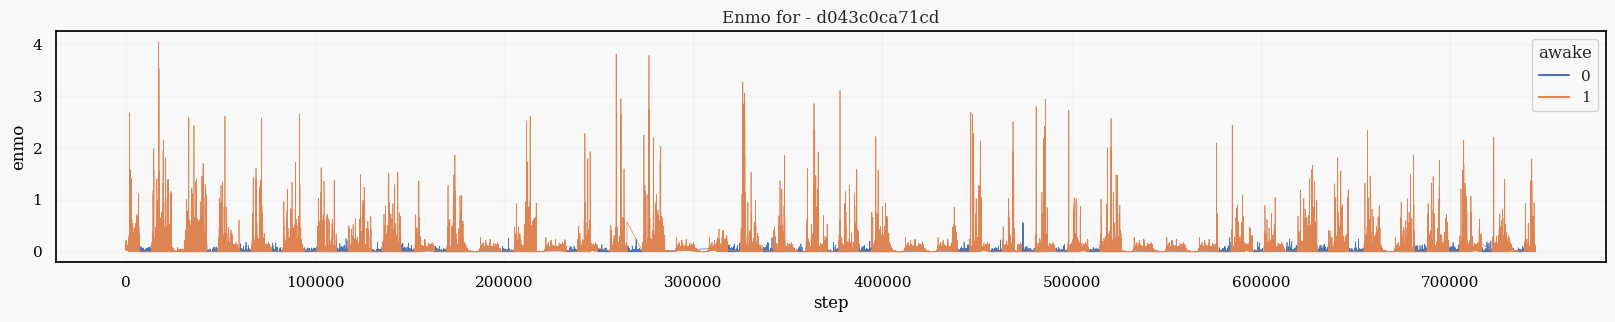

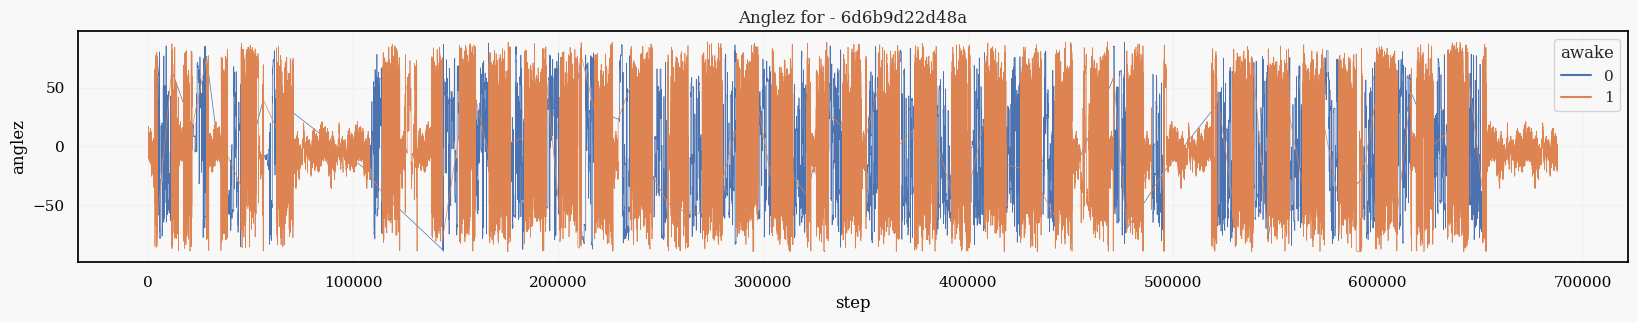

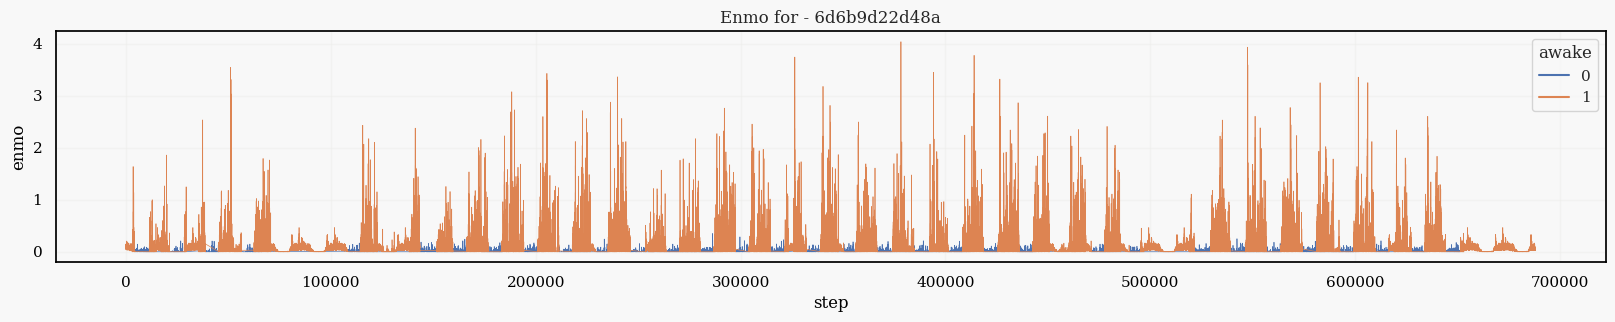

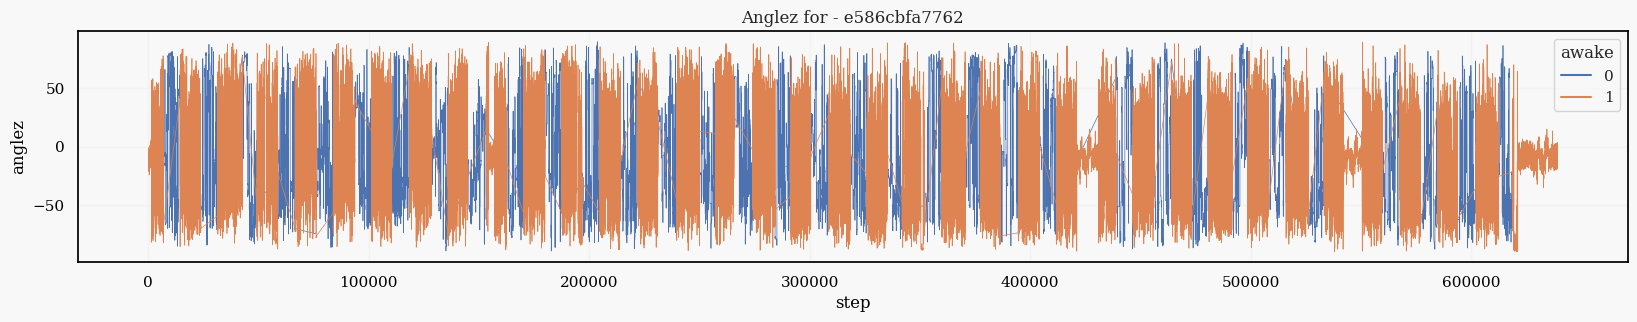

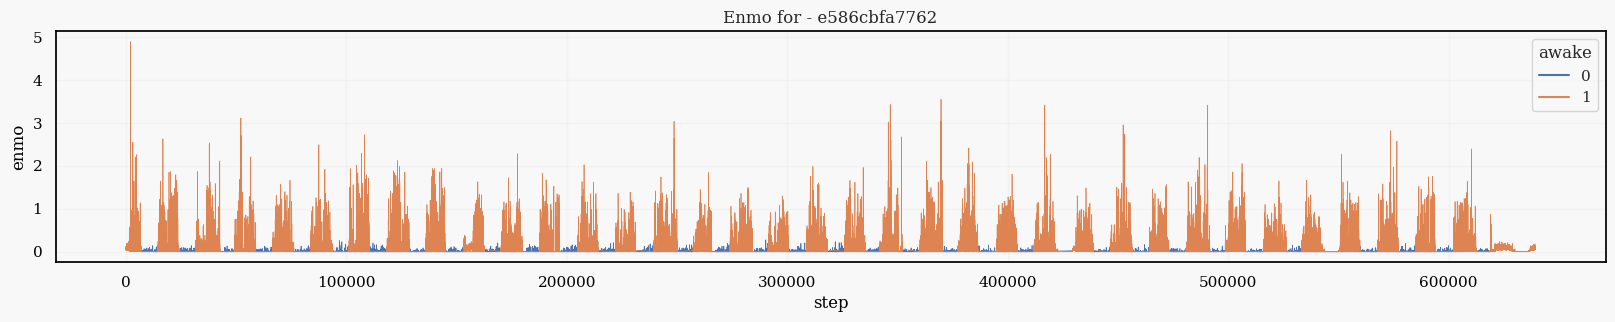

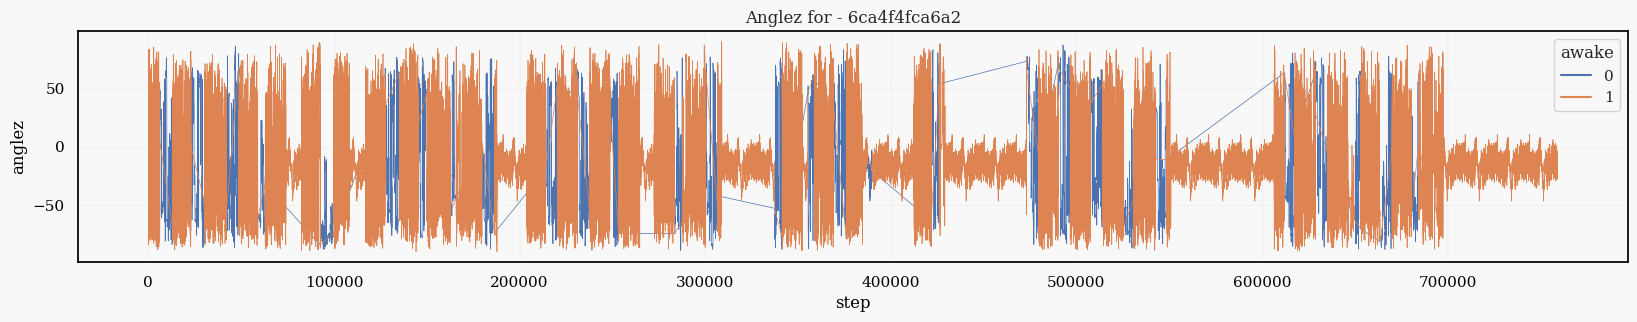

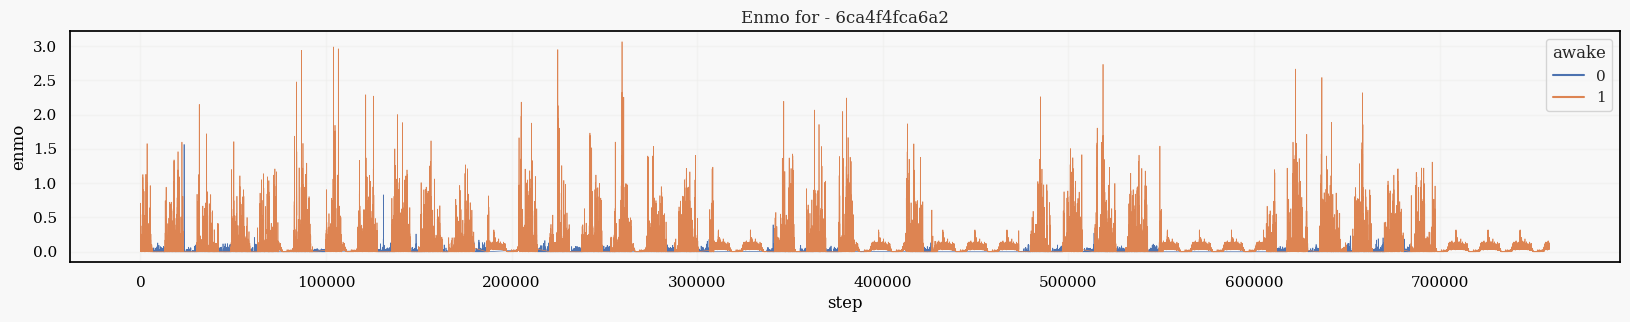

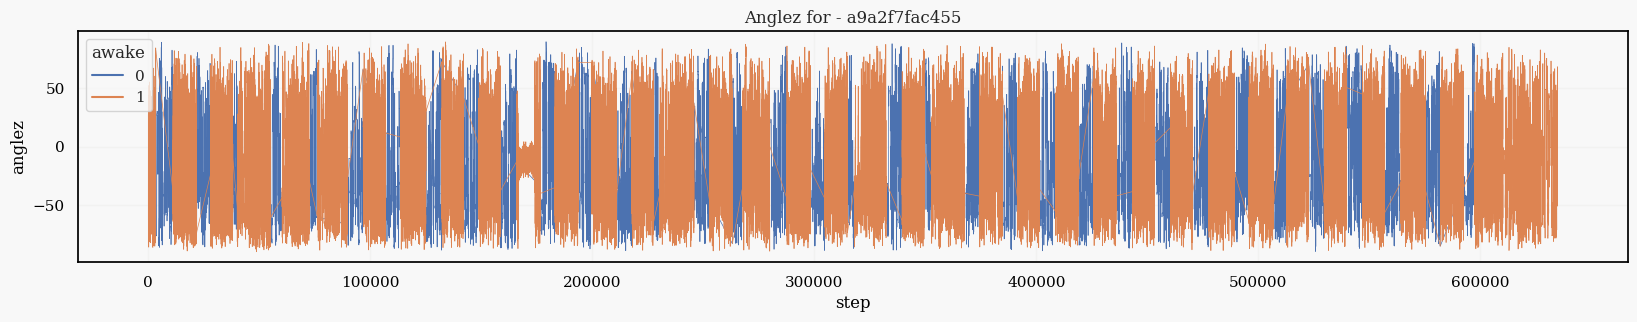

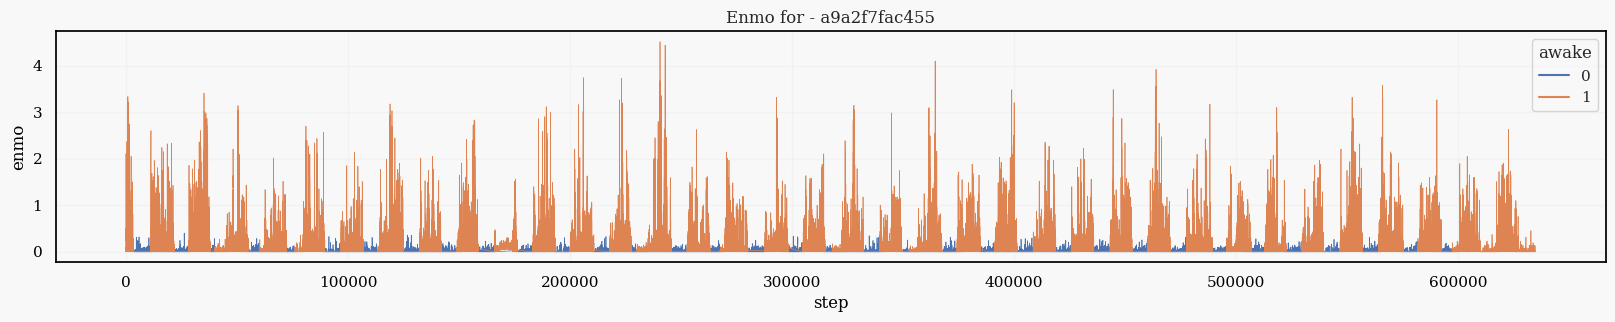

In [25]:
for series_id in top5id:
    train = get_series_data(series_id,train_series,train_events)
    train['anglez'] = train['anglez'].astype('float32')
    train['enmo'] = train['enmo'].astype('float32')

    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.title(f'Anglez for - '+series_id)
    plt.show();

    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.title(f'Enmo for - '+series_id)
    plt.show();